# 구내식당 식수 인원 예측

> 목적
- 구내식당의 요일별 점심, 저녁식사를 먹는 인원을 예측

> 평가
- 평가산식 : MAE(Mean Absolute Error)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor
import xgboost

In [5]:
# 사용자 운영체제 확인
import os
os.name

# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# Dataset

In [8]:
df = pd.read_csv('./data/train.csv')
df.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [11]:
df.shape

(1205, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


# EDA

## Correlation

> 상관관계
- 중식계, 석식계가 상관관계가 있다 (상관관계가 있다고 인과관계는 될수없지만,)
- 점심에도 먹은 사람은 저녁에도 먹을 가능성이 크다고 생각. 점심때 밖에서 먹지 않은 사람들은 시간을 효율적으로 쓰고 싶어하거나
- 음식에 대해 딱히 관심이 없을수도있다생각. 그냥 살기위해 먹는 사람들일수도 있다 생각.
- 그래서 이 사람들은 시간이 가장 중요하다 생각.
- 그래도 너무 맛이없으면 밖에서 사먹을 수도 있다는게 두번째 가설. 보통 음식은 밥, 국 , 메인반찬이 중요하므로
- 음식이 너무 맛이없지않는한 웬만하면 구내식당을 이용할거라 예측.

In [10]:
df.corr()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
본사정원수,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,-0.173852
본사휴가자수,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,-0.316894
본사출장자수,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,0.571168
현본사소속재택근무자수,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057534
중식계,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,0.508287
석식계,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.508287,1.000000


## 요일별

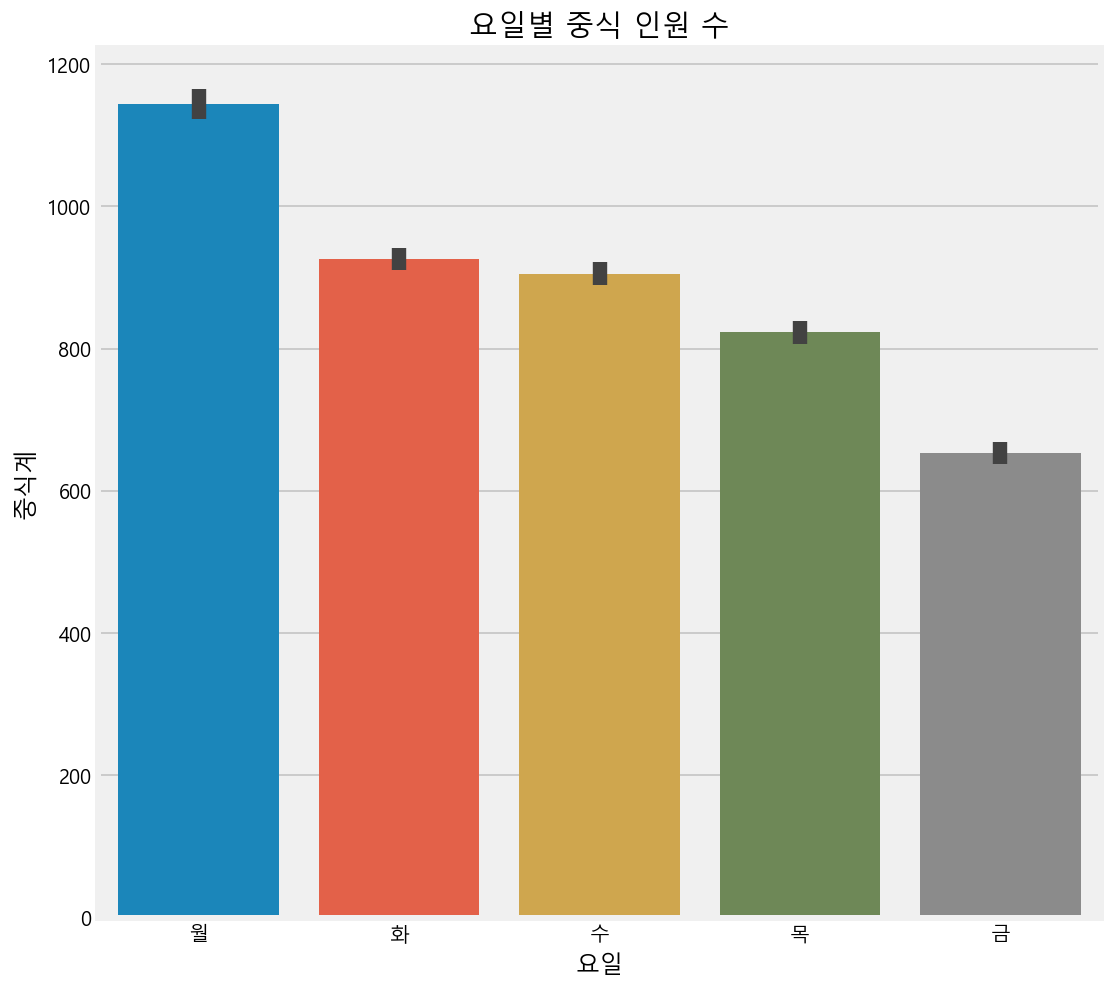

In [19]:
# 월요일이 가장 많고 금요일로 갈수록 줄어든다.
plt.figure(figsize=(8,8))

sns.barplot(x="요일", y="중식계", data=df)
plt.title("요일별 중식 인원 수")
plt.show()

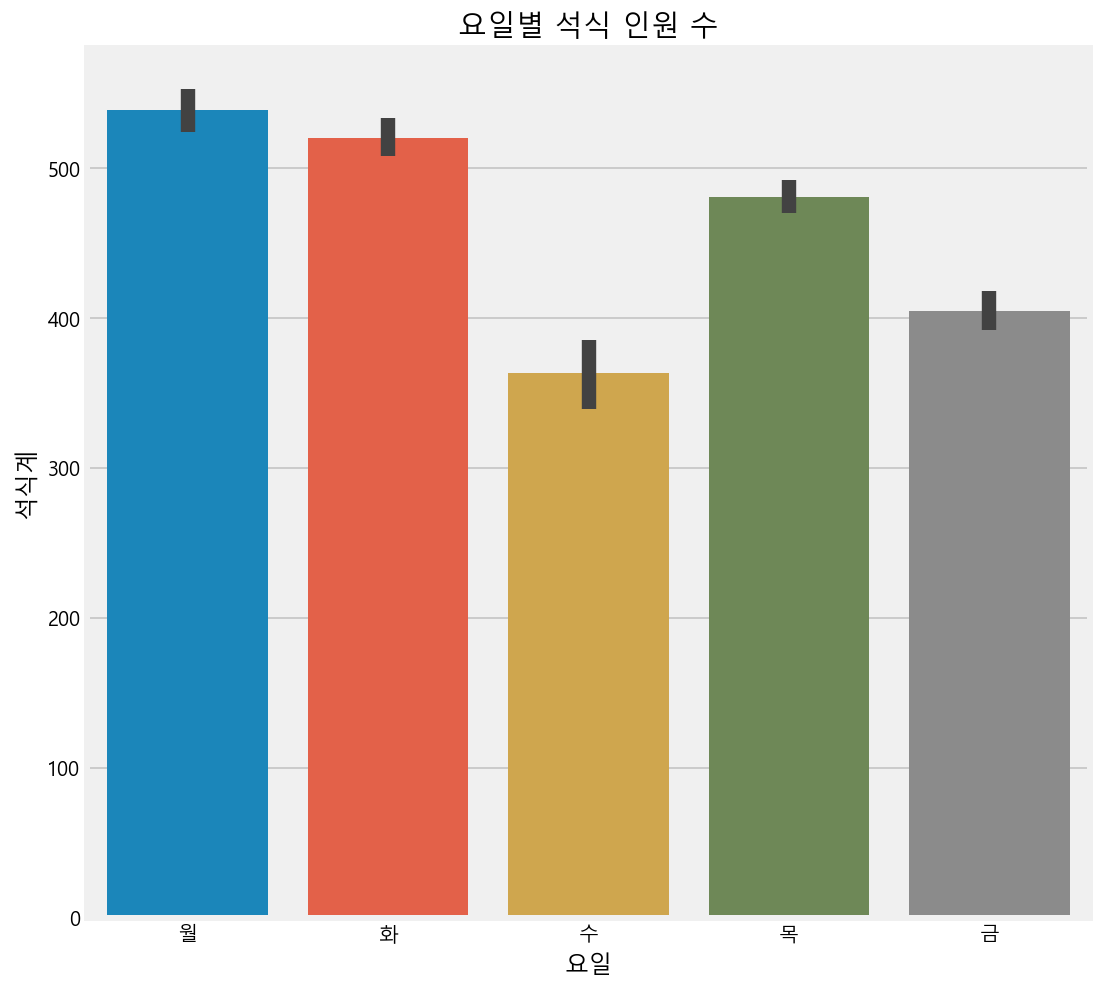

In [18]:
#수요일 금요일이 가장 적은데
#그이유는 수요일날 한번 쉬는 의미에서 약속이 많을수 있다 생각.
#금요일 역시 약속이 있어서 나가서 먹을거라 생각
#=> 월,화,목 일 열심히 // 수,금은 좀 힘들어서 쉬는시간 필요하다 생각.

plt.figure(figsize=(8,8))

sns.barplot(x="요일", y="석식계", data=df)
plt.title("요일별 석식 인원 수")
plt.show()

## 중식 / 석식

In [21]:
print(df['본사정원수'].max()) #총인원 3305
print('\n')
print(df['중식계'].describe()) #최대 1459
print('\n')
print(df['석식계'].describe()) #최대 905

3305


count    1205.000000
mean      890.334440
std       209.505057
min       296.000000
25%       758.000000
50%       879.000000
75%      1032.000000
max      1459.000000
Name: 중식계, dtype: float64


count    1205.000000
mean      461.772614
std       139.179202
min         0.000000
25%       406.000000
50%       483.000000
75%       545.000000
max       905.000000
Name: 석식계, dtype: float64


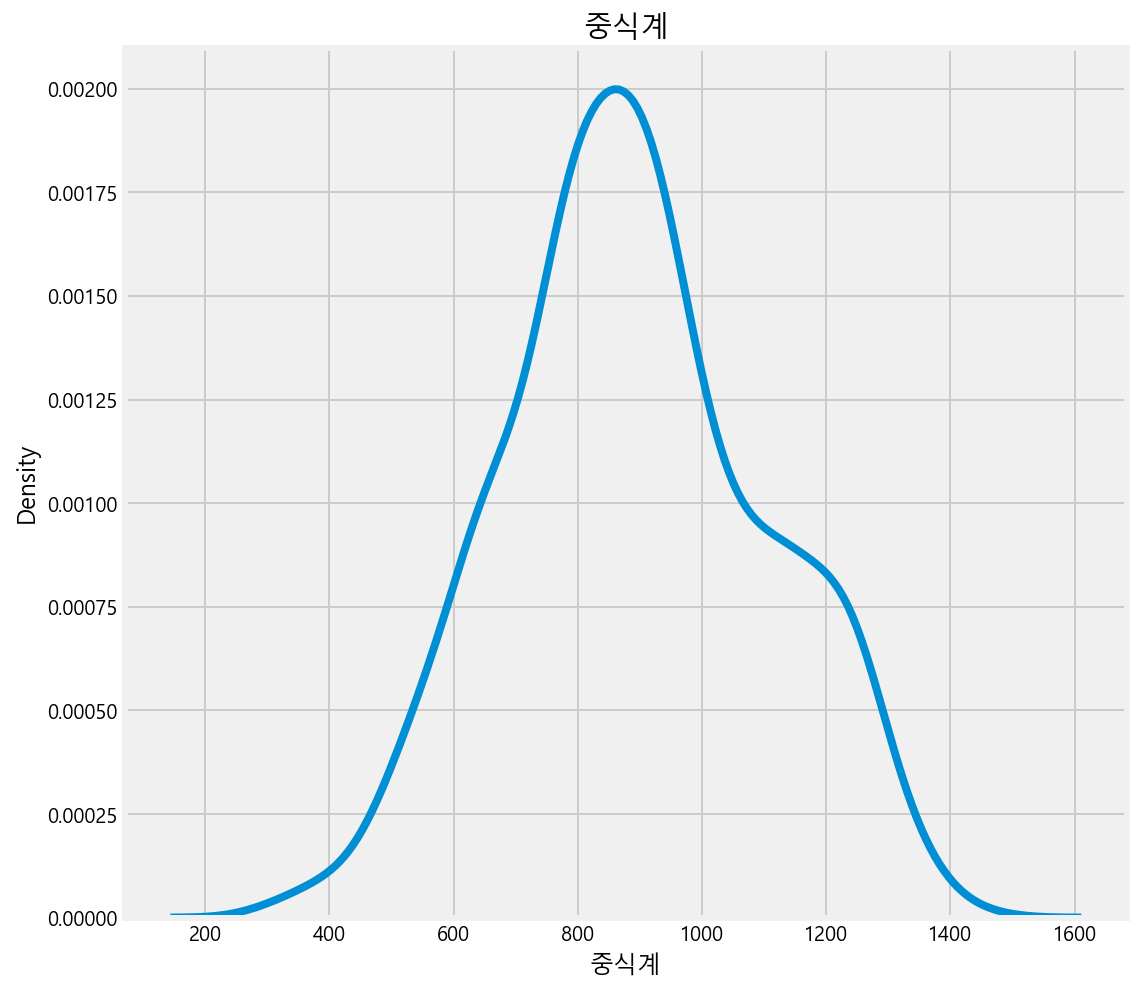

In [17]:
plt.figure(figsize=(8,8))
sns.kdeplot(df['중식계'])
plt.title("중식계")
plt.show()

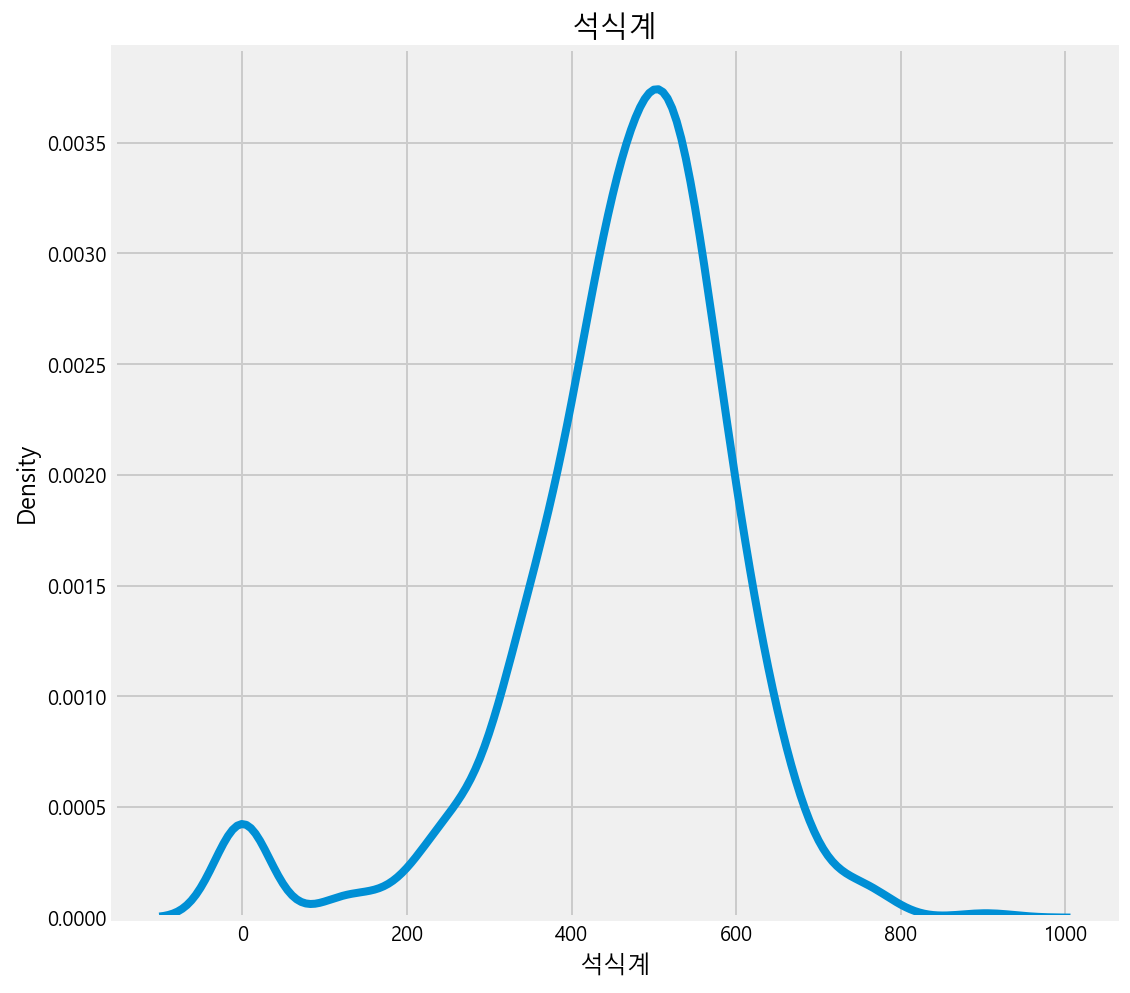

In [20]:
plt.figure(figsize=(8,8))
sns.kdeplot(df['석식계'])
plt.title("석식계")
plt.show()

# 전처리

## Train

In [25]:
df.columns = ['date','day','numbers','dayoff','work','outsidework','workfhome','break','lunch','dinner','lunch_t','dinner_t']
df.head(2)

,date,day,numbers,dayoff,work,outsidework,workfhome,break,lunch,dinner,lunch_t,dinner_t
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


### 날짜 정리

In [26]:
df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')
df['date'] = df['date'].dt.strftime('%m%d')
df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]

df.drop(['date','break'], inplace=True , axis=1) # 아침은 영향이 없을것같으므로 삭제

In [28]:
df.head(2)

,day,numbers,dayoff,work,outsidework,workfhome,lunch,dinner,lunch_t,dinner_t,yearmonth,Month,Date
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,201602,02,01
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,201602,02,02


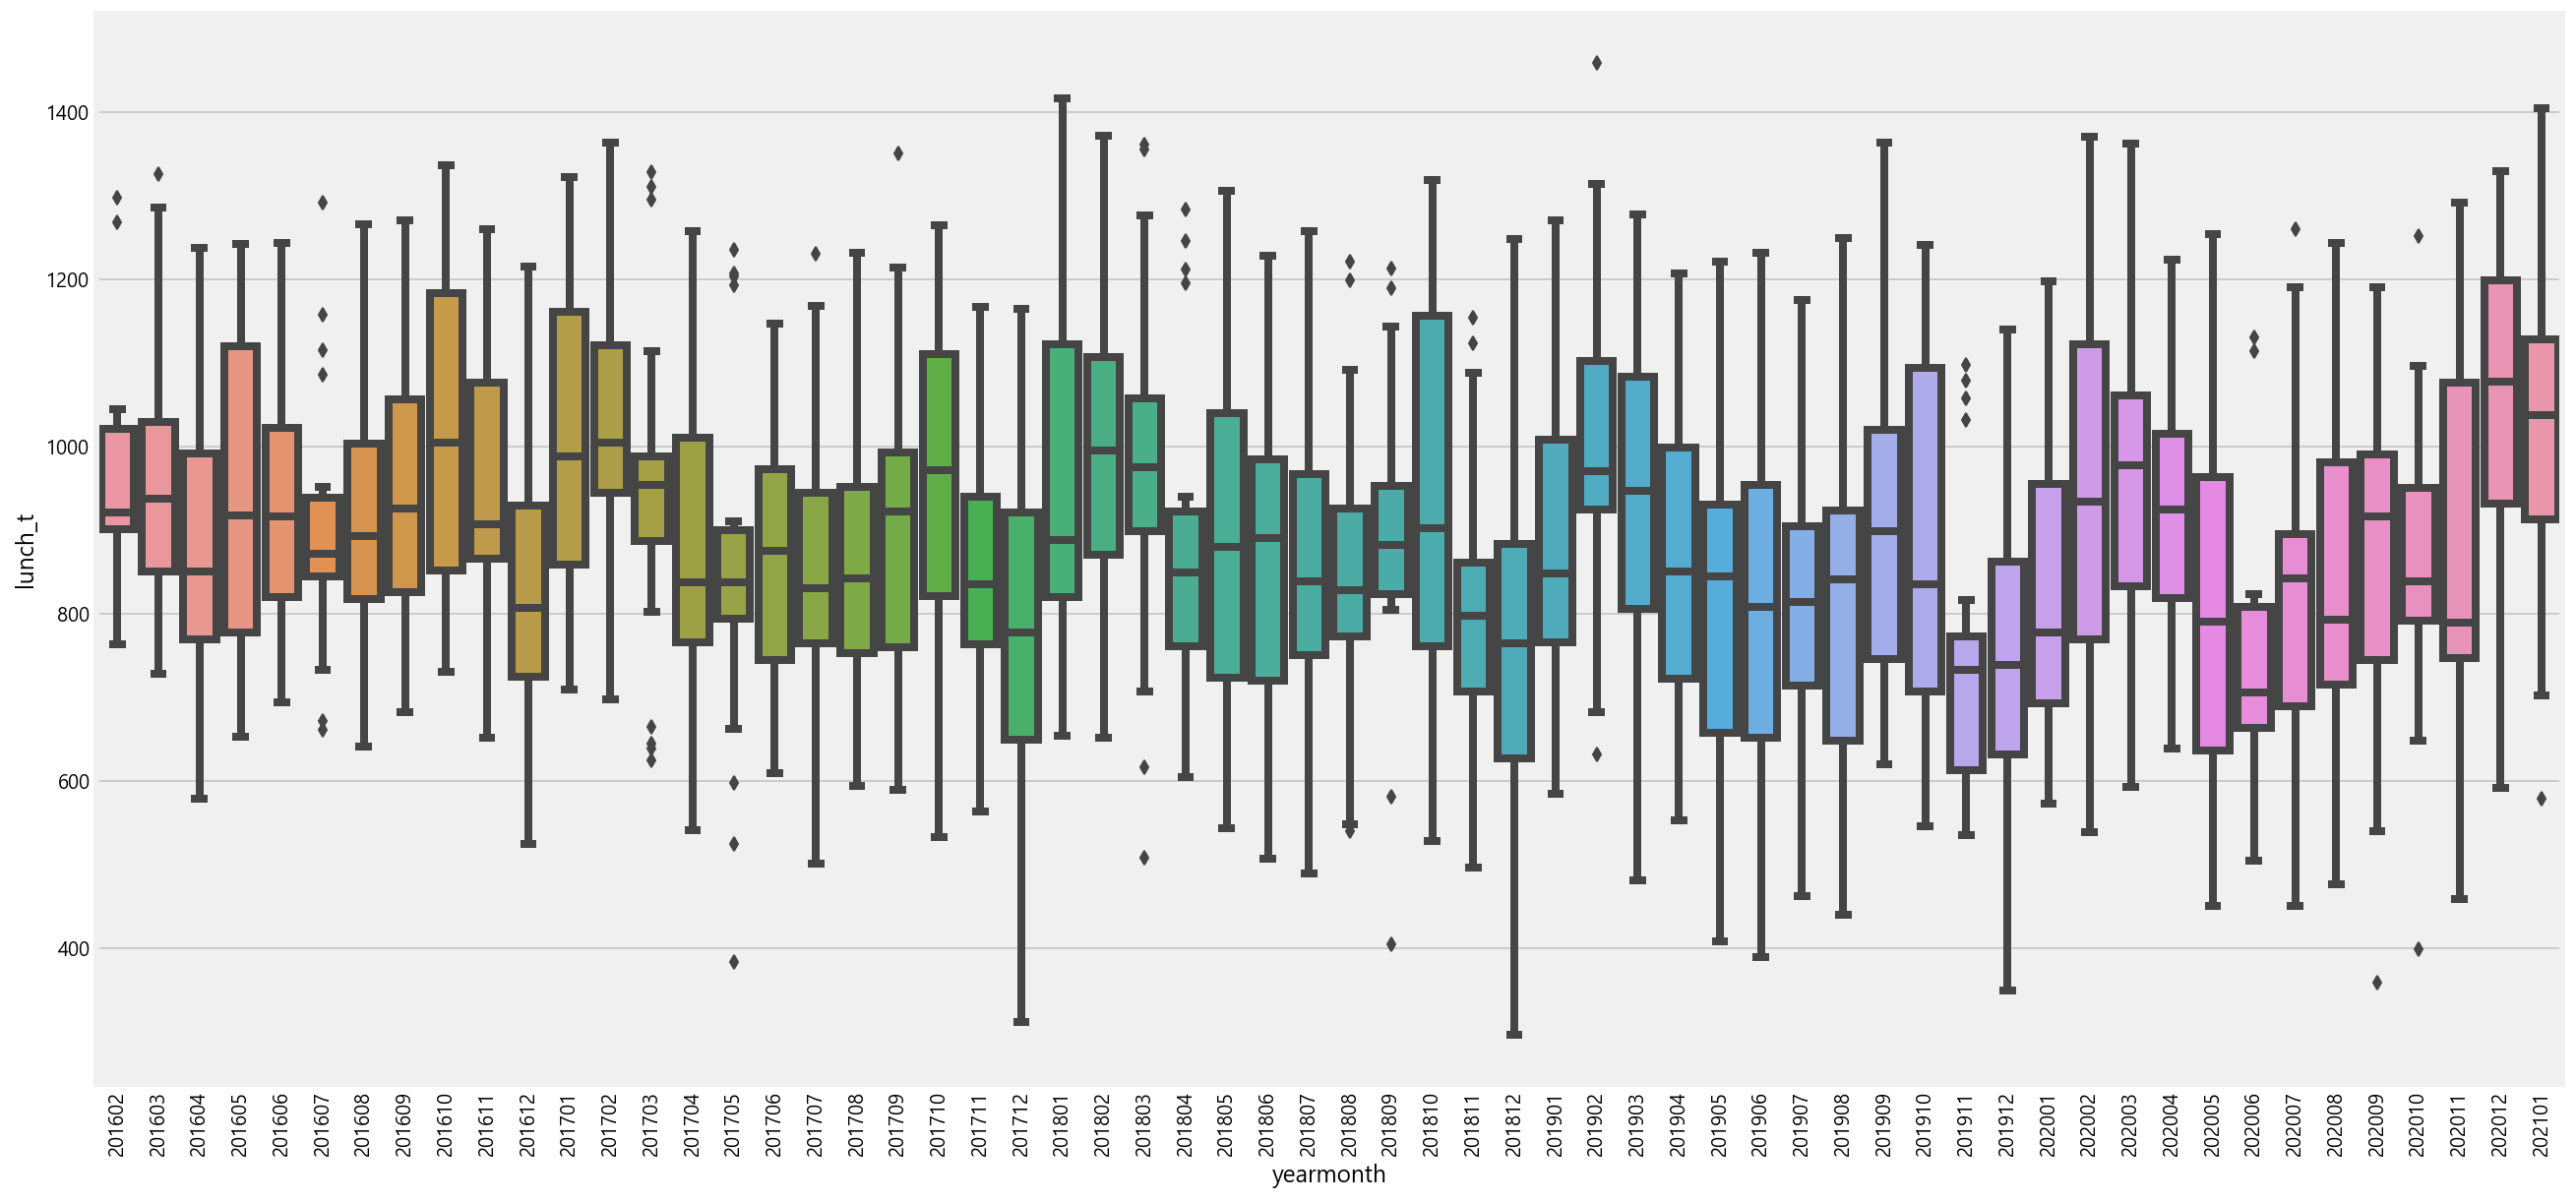

In [29]:
#월별 점심떄 사람수
plt.figure(figsize=(20,10))
rot = sns.boxplot(x='yearmonth',y='lunch_t', data = df)

for item in rot.get_xticklabels():
    item.set_rotation(90)
#2017 년부 12월에 먹는 사람수가 좀 줄어든다.
#연말이라 회식이많은것같다. 그래서 밖에서 사먹고 와서 그런것같다.
#생각보다 코라나로인해 확 줄거나 그런것은 안보이는 것같다.

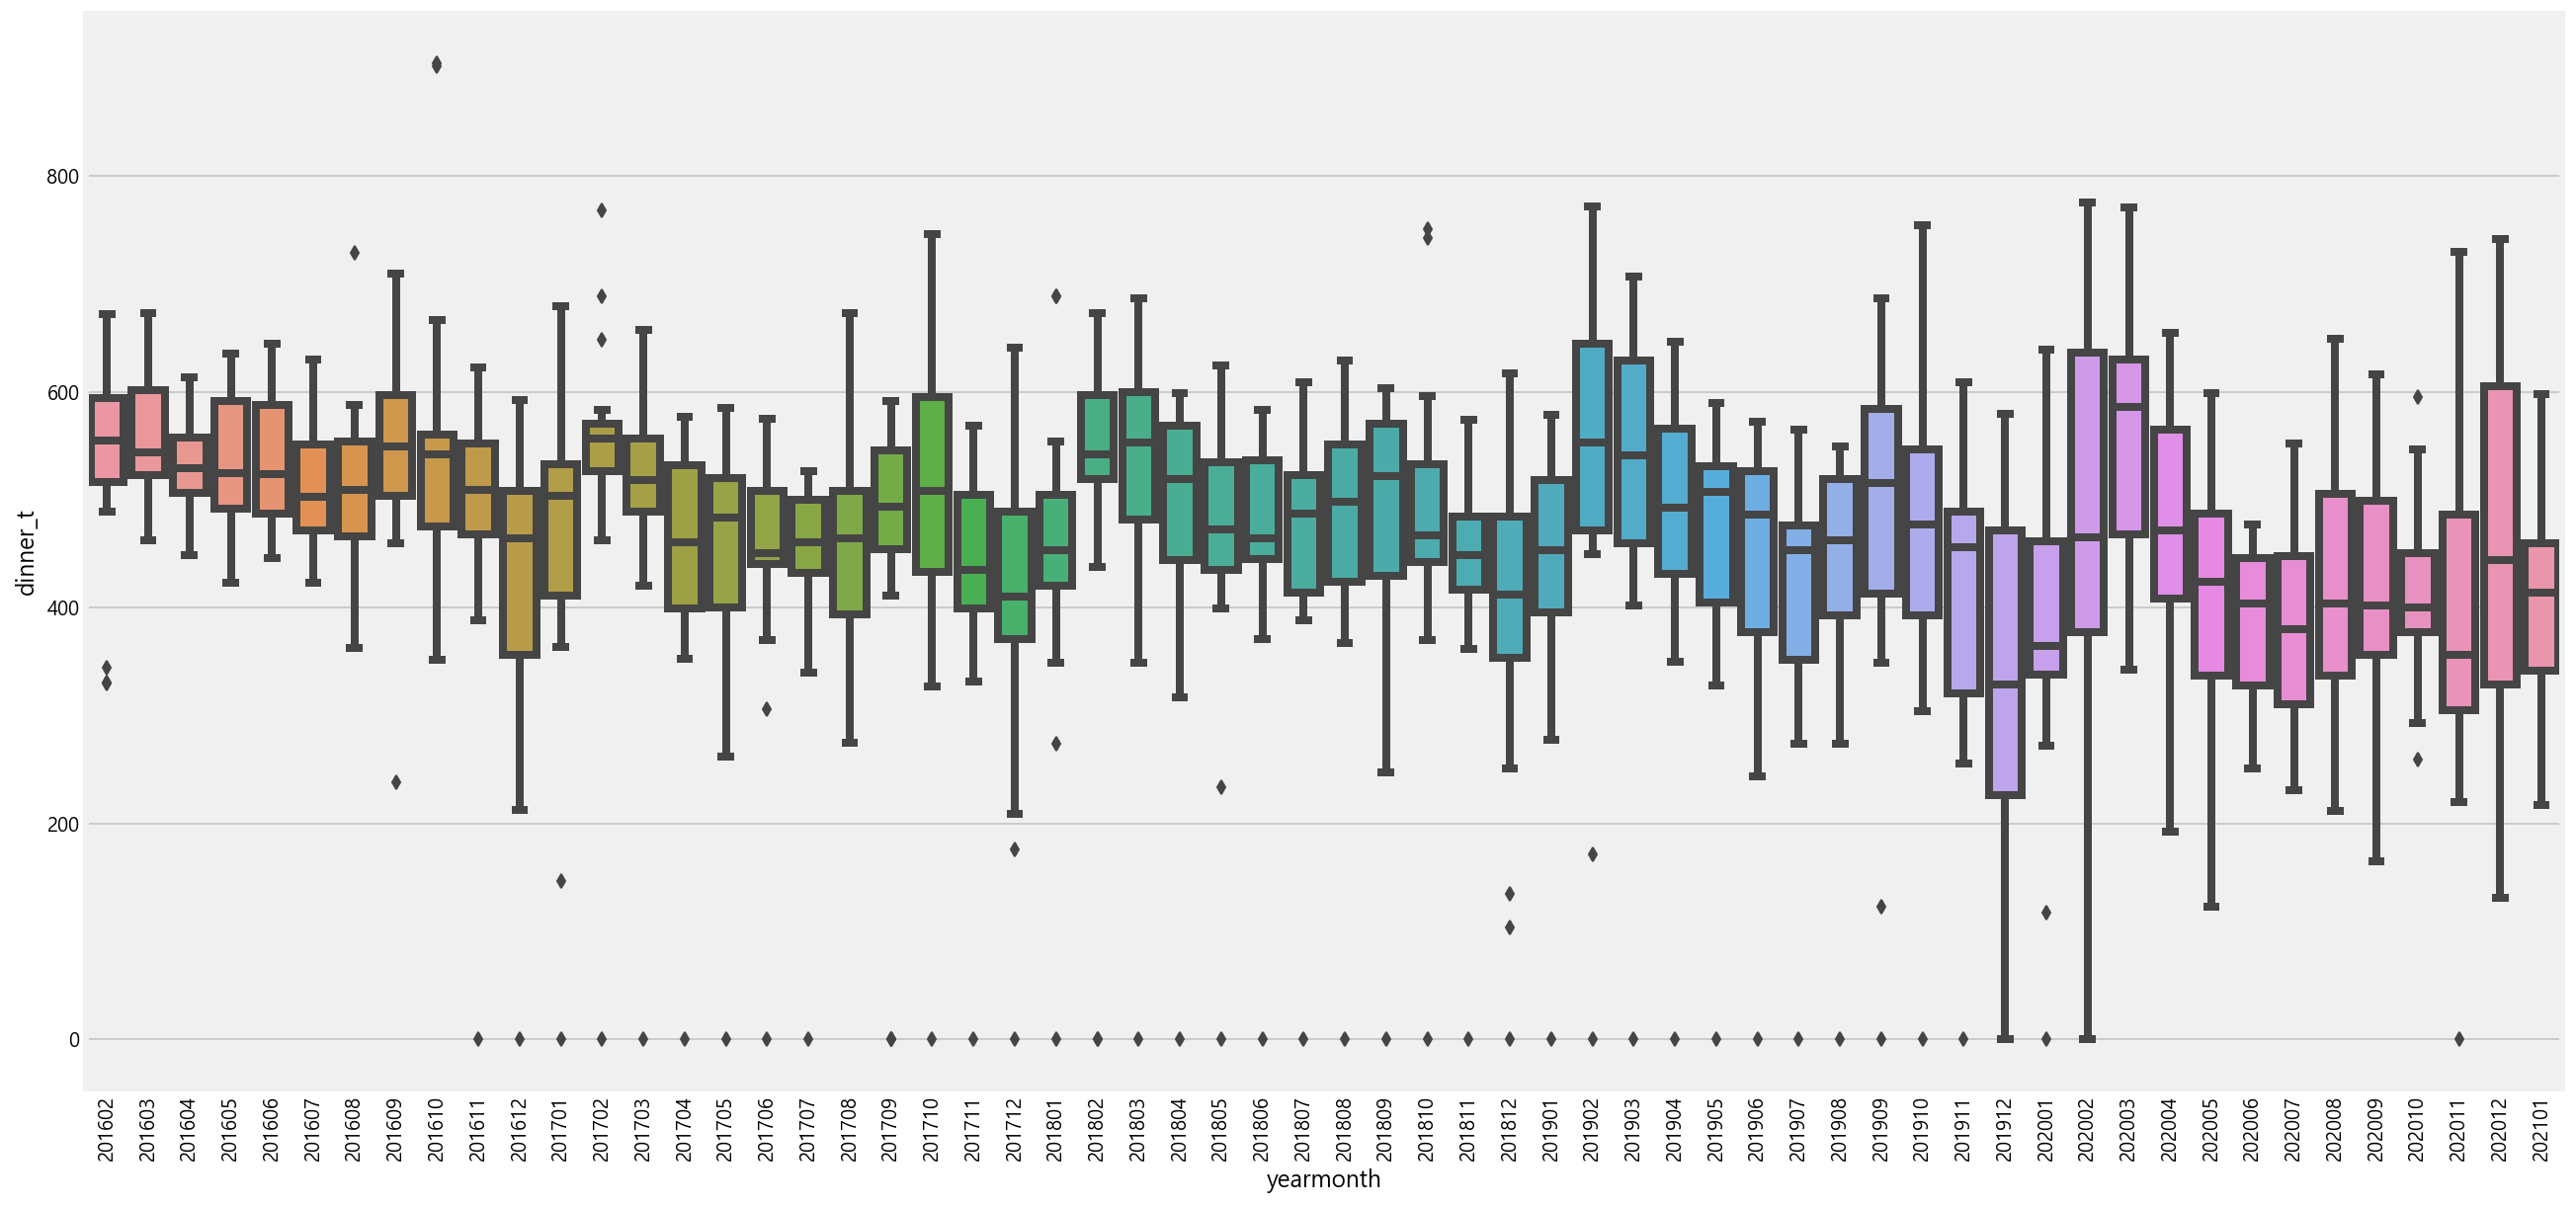

In [30]:
#월별 저녁
plt.figure(figsize=(20,10))
rot = sns.boxplot(x='yearmonth',y='dinner_t', data = df)

for item in rot.get_xticklabels():
    item.set_rotation(90)

In [31]:
df.drop('yearmonth', inplace=True , axis=1)

### 메뉴 구분

#### 점심

In [32]:
df.head(2)

,day,numbers,dayoff,work,outsidework,workfhome,lunch,dinner,lunch_t,dinner_t,Month,Date
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,02,01
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,02,02


In [33]:
# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

In [34]:
for bob in range(len(df)): # 밥은 큰 차이가 없을것같으므로 쌀밥은 다 밥으로 통일
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

In [35]:
lunch_menu[:3]

[['밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치']]

In [36]:
df['lunch_menu'] = lunch_menu
df.head(2)

,day,numbers,dayoff,work,outsidework,workfhome,lunch,dinner,lunch_t,dinner_t,Month,Date,lunch_menu
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,02,01,"[밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]"
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,02,02,"[밥, 김치찌개, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추겉절이]"


In [37]:
# 위에서 언급한 메인, 국, 반찬만 나누어주기

bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [38]:
#누락이 있으면 안되므로 확인해주자

print(len(bob))
print(len(soup))
print(len(main))
print('--')
print(len(df))

1205
1205
1205
--
1205


In [39]:
#확인후에 추가
df['bob'] = bob
df['soup'] = soup
df['main'] = main

In [40]:
df.head(2)

,day,numbers,dayoff,work,outsidework,workfhome,lunch,dinner,lunch_t,dinner_t,Month,Date,lunch_menu,bob,soup,main
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,02,01,"[밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]",밥,오징어찌개,쇠불고기
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,02,02,"[밥, 김치찌개, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추겉절이]",밥,김치찌개,가자미튀김


In [41]:
df['bob'].value_counts() #밥은 딱히 영향이 없을것같다.

밥              1003
콩나물밥             23
카레덮밥             18
나물비빔밥            15
곤드레밥*강된장         12
단호박영양밥           10
곤드레밥*양념장          8
카레라이스             8
곤드레밥              8
비빔밥               8
김치제육덮밥            8
짜장덮밥              6
낙지비빔밥             6
마파두부덮밥            5
콩나물밥*양념장          5
산채비빔밥             5
짜장밥               4
열무보리비빔밥           4
소불고기덮밥            3
열무비빔밥             3
봄나물비빔밥            3
참치회덮밥             2
콩나물밥*달래장          2
<초복특식>            2
단호박카레라이스          2
곤드레밥*간장양념         2
전주비빔밥             1
호박된장국             1
소고기콩나물밥*양념        1
닭살카레라이스           1
오므라이스             1
불고기비빔밥            1
삼계탕               1
고기듬뿍카레라이스         1
파인애플볶음밥           1
버섯영양밥             1
계란채소볶음밥           1
전주비빔밥*약고추장        1
오곡밥               1
돈육버섯고추장덮밥         1
연복풍덮밥             1
봄새싹비빔밥            1
산채비빔밥*강된장         1
비빔밥*약고추장          1
야채볶음밥*짜장소스        1
건강비빔밥*약고추장        1
불고기덮밥             1
열무보리비빔밥/강된장       1
낙지볶음밥             1
새우날치알볶음밥          1


In [42]:
df['soup'].value_counts()

맑은국       46
콩나물국      44
된장찌개      37
어묵국       31
아욱국       28
          ..
해물완자전      1
호박잎된장국     1
어묵매운탕      1
쪽파국        1
홍초콩나물국     1
Name: soup, Length: 272, dtype: int64

In [43]:
df['main'].value_counts()

오징어볶음        32
닭갈비          30
버섯불고기        29
훈제오리구이       27
돈육굴소스볶음      25
             ..
꽁치한마리레몬구이     1
묵은지닭볶음탕       1
차돌비빔국수        1
김치전           1
바베큐폭립         1
Name: main, Length: 391, dtype: int64

#### 저녁

In [45]:
dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ')
    tmp = ' '.join(tmp).split()    

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

In [46]:
df['dinner_menu'] = dinner_menu

In [47]:
len(df['dinner_menu'])

1205

In [48]:
dinner_menu[0:5]

[['쌀밥/잡곡밥', '육개장', '자반고등어구이', '두부조림', '건파래무침', '포기김치'],
 ['콩나물밥*양념장', '어묵국', '유산슬', '아삭고추무침', '바나나', '포기김치'],
 ['쌀밥/잡곡밥', '청국장찌개', '황태양념구이', '고기전', '새송이버섯볶음', '포기김치'],
 ['미니김밥*겨자장', '우동', '멕시칸샐러드', '군고구마', '무피클', '포기김치'],
 ['쌀밥/잡곡밥', '차돌박이찌개', '닭갈비', '감자소세지볶음', '콩나물무침', '포기김치']]

In [49]:
bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:
    
    
    if len(word) == 0:
        bobd.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        soupd.append('None')
        maind.append('None')
    elif '*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의달' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기계발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '*자기계발의날*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기개발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')

    else:
        bobd.append(word[0])
        soupd.append(word[1])
        maind.append(word[2])

In [50]:
#다들어왔는지 확인
print(len(dinner_menu))
print(len(bobd))
print(len(soupd))
print(len(maind))

1205
1205
1205
1205


In [51]:
df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

In [52]:
df['maind'].value_counts()[:10]

None       41
떡볶이        16
닭갈비        16
돈육강정       15
돈육장조림      14
돈육굴소스볶음    14
유린기        14
깐풍기        14
고추잡채*꽃빵    14
주꾸미볶음      13
Name: maind, dtype: int64

In [53]:
df['soupd'].value_counts()[:10]

None     41
잔치국수     37
맑은국      33
된장찌개     30
육개장      29
가쯔오장국    29
미소장국     28
부대찌개     25
우동       23
닭개장      23
Name: soupd, dtype: int64

### Lunch Train

In [54]:
# Lunch Train 완성
#lunch_train
train = df[
    ['day','numbers','dayoff','work','outsidework','workfhome','lunch_t','Month','Date','bob','soup','main']
]

In [55]:
# encoding

train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes # 0, 1, 2 ...로 변경


train['bob'] =  train['bob'].astype('category')
train['bob'] = train.bob.cat.codes

train['soup'] =  train['soup'].astype('category')
train['soup'] = train.soup.cat.codes

train['main'] =  train['main'].astype('category')
train['main'] = train.main.cat.codes

In [56]:
train['present'] = train['numbers']-train['dayoff']-train['work']-train['outsidework']

In [57]:
train.head()

,day,numbers,dayoff,work,outsidework,workfhome,lunch_t,Month,Date,bob,soup,main,present
0,3,2601,50,150,238,0.0,1039.0,02,01,22,189,236,2163
1,4,2601,50,173,319,0.0,867.0,02,02,22,28,8,2059
2,2,2601,56,180,111,0.0,1017.0,02,03,49,249,334,2254
3,1,2601,104,220,355,0.0,978.0,02,04,22,149,309,1922
4,0,2601,278,181,34,0.0,925.0,02,05,22,75,106,2108


In [58]:
train.corr() # 밥, 국, 메인 반찬이 약간의 상관관계를 보인다 

,day,numbers,dayoff,work,outsidework,workfhome,lunch_t,bob,soup,main,present
day,1.000000,0.004999,-0.210219,-0.447183,0.539062,0.028364,0.584193,-0.051779,0.039582,0.033023,-0.327922
numbers,0.004999,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,0.008470,-0.047180,0.063892,0.409730
dayoff,-0.210219,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,0.008260,-0.033509,0.022062,-0.134040
work,-0.447183,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,0.062909,-0.016055,-0.038943,0.244995
outsidework,0.539062,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,-0.182796,0.078805,0.017750,-0.696646
workfhome,0.028364,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057818,-0.006933,0.029749,0.178831
lunch_t,0.584193,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,-0.041401,0.060575,0.041329,-0.290912
bob,-0.051779,0.008470,0.008260,0.062909,-0.182796,-0.057818,-0.041401,1.000000,-0.094330,-0.021443,0.169876
soup,0.039582,-0.047180,-0.033509,-0.016055,0.078805,-0.006933,0.060575,-0.094330,1.000000,0.030518,-0.087686
main,0.033023,0.063892,0.022062,-0.038943,0.017750,0.029749,0.041329,-0.021443,0.030518,1.000000,0.020313


In [59]:
train.to_csv('enco_train_lunch.csv',index=False)

### Dinner Train

In [60]:
train = df[
    ['day','numbers','dayoff','work','outsidework','workfhome','dinner_t','Month','Date','bobd','soupd','maind']
]

In [61]:
#train_dinner 데이터 같은 경우에는 'None' 값이 들어가있어서
#제거 해주는게 가장 좋을것같아서 없애줬다.
train = train[~train['bobd'].str.contains("None", na=False, case=False)]

In [62]:
train.head()

,day,numbers,dayoff,work,outsidework,workfhome,dinner_t,Month,Date,bobd,soupd,maind
0,월,2601,50,150,238,0.0,331.0,02,01,쌀밥/잡곡밥,육개장,자반고등어구이
1,화,2601,50,173,319,0.0,560.0,02,02,콩나물밥*양념장,어묵국,유산슬
2,수,2601,56,180,111,0.0,573.0,02,03,쌀밥/잡곡밥,청국장찌개,황태양념구이
3,목,2601,104,220,355,0.0,525.0,02,04,미니김밥*겨자장,우동,멕시칸샐러드
4,금,2601,278,181,34,0.0,330.0,02,05,쌀밥/잡곡밥,차돌박이찌개,닭갈비


In [63]:
# encoding

train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes


train['bobd'] =  train['bobd'].astype('category')
train['bobd'] = train.bobd.cat.codes

train['soupd'] =  train['soupd'].astype('category')
train['soupd'] = train.soupd.cat.codes

train['maind'] =  train['maind'].astype('category')
train['maind'] = train.maind.cat.codes

In [64]:
train['present'] = train['numbers']-train['dayoff']-train['work']-train['outsidework']

In [65]:
train.corr() 

,day,numbers,dayoff,work,outsidework,workfhome,dinner_t,bobd,soupd,maind,present
day,1.000000,0.000103,-0.217477,-0.448551,0.550560,0.027610,0.367746,-0.031836,-0.049255,-0.027405,-0.339011
numbers,0.000103,1.000000,0.244031,-0.060470,0.148530,0.459453,-0.236324,0.233612,-0.040918,-0.016451,0.414056
dayoff,-0.217477,0.244031,1.000000,-0.267355,-0.247829,0.063480,-0.439108,0.095060,0.049480,-0.033118,-0.123294
work,-0.448551,-0.060470,-0.267355,1.000000,-0.304423,-0.352901,-0.188894,-0.134922,-0.012290,0.051699,0.239584
outsidework,0.550560,0.148530,-0.247829,-0.304423,1.000000,0.144985,0.577148,0.002529,-0.016797,0.047346,-0.689208
workfhome,0.027610,0.459453,0.063480,-0.352901,0.144985,1.000000,-0.130644,0.357199,-0.055294,-0.035213,0.200098
dinner_t,0.367746,-0.236324,-0.439108,-0.188894,0.577148,-0.130644,1.000000,-0.131424,0.028299,0.048750,-0.445447
bobd,-0.031836,0.233612,0.095060,-0.134922,0.002529,0.357199,-0.131424,1.000000,-0.039370,-0.085033,0.127680
soupd,-0.049255,-0.040918,0.049480,-0.012290,-0.016797,-0.055294,0.028299,-0.039370,1.000000,-0.000109,-0.038519
maind,-0.027405,-0.016451,-0.033118,0.051699,0.047346,-0.035213,0.048750,-0.085033,-0.000109,1.000000,-0.048079


In [66]:
train.to_csv('enco_train_dinner.csv',index=False)

## Test

In [81]:
df = pd.read_csv('./data/test.csv')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


In [83]:
df.columns = ['date','day','numbers','dayoff','work','outsidework','workfhome','break','lunch','dinner']
df.head(2)

,date,day,numbers,dayoff,work,outsidework,workfhome,break,lunch,dinner
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지


In [84]:
df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%m%d')
df.head(2)

,date,day,numbers,dayoff,work,outsidework,workfhome,break,lunch,dinner,yearmonth
0,0127,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,202101
1,0128,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,202101


In [85]:
df.drop('yearmonth', inplace=True , axis=1)

In [86]:
df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]
df.drop(['date','break'], inplace=True , axis=1)

In [87]:
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

In [88]:
df['lunch_menu'] = lunch_menu

In [89]:
for bob in range(len(df)):
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

In [90]:
bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [91]:
print(len(bob))
print(len(soup))
print(len(main))
print('--')
print(len(df))

50
50
50
--
50


In [92]:
df['bob'] = bob
df['soup'] = soup
df['main'] = main

In [93]:
# 저녁도 바꾸어주자
dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ') 
    tmp = ' '.join(tmp).split()   
    
    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

In [94]:
df['dinner_menu'] = dinner_menu

In [95]:
len(dinner_menu)

50

In [96]:
bobd=[]
soupd=[]
maind=[]

for i in range(len(df)):
    if dinner_menu[i][0]:
        bobd.append(dinner_menu[i][0])
    if dinner_menu[i][1]:
        soupd.append(dinner_menu[i][1])
    if dinner_menu[i][2]:
        maind.append(dinner_menu[i][2])

In [97]:
df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

In [98]:
#lunch
test = df[
    ['day','numbers','dayoff','work','outsidework','workfhome','Month','Date','bob','soup','main']
]

In [99]:
# encoding

test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bob'] =  test['bob'].astype('category')
test['bob'] = test.bob.cat.codes

test['soup'] =  test['soup'].astype('category')
test['soup'] = test.soup.cat.codes

test['main'] =  test['main'].astype('category')
test['main'] = test.main.cat.codes

In [100]:
test['present'] = test['numbers']-test['dayoff']-test['work']-test['outsidework']

In [101]:
test.head()

,day,numbers,dayoff,work,outsidework,workfhome,Month,Date,bob,soup,main,present
0,2,2983,88,182,5,358.0,01,27,0,9,15,2708
1,1,2983,104,212,409,348.0,01,28,0,35,35,2258
2,0,2983,270,249,0,294.0,01,29,0,41,29,2464
3,3,2924,108,154,538,322.0,02,01,0,19,33,2124
4,4,2924,62,186,455,314.0,02,02,0,21,7,2221


In [102]:
test.to_csv('enco_test_lunch.csv', index=False)

In [103]:
#dinner

test = df[
    ['day','numbers','dayoff','work','outsidework','workfhome','Month','Date', 'bobd','soupd','maind']
]

In [104]:
# encoding

test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bobd'] =  test['bobd'].astype('category')
test['bobd'] = test.bobd.cat.codes

test['soupd'] =  test['soupd'].astype('category')
test['soupd'] = test.soupd.cat.codes

test['maind'] =  test['maind'].astype('category')
test['maind'] = test.maind.cat.codes

In [105]:
test['present'] = test['numbers']-test['dayoff']-test['work']-test['outsidework']

In [106]:
test.to_csv('enco_test_dinner.csv', index=False)

## 점심/저녁 병합 데이터

### Train

In [108]:
df = pd.read_csv('./data/train.csv')

In [109]:
df.columns = ['date','day','numbers','dayoff','work','outsidework','workfhome','break','lunch','dinner','lunch_t','dinner_t']

df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')

df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%m%d')

df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]
df.drop(['date','break'], inplace=True , axis=1)

In [110]:
df.drop('yearmonth', inplace=True , axis=1)

In [111]:
# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

In [112]:
for bob in range(len(df)): # 밥은 큰 차이가 없을것같으므로 쌀밥은 다 밥으로 통일
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

In [113]:
df['lunch_menu'] = lunch_menu

In [114]:
bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [115]:
df['bob'] = bob
df['soup'] = soup
df['main'] = main

In [116]:
dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ')
    tmp = ' '.join(tmp).split()    

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

In [117]:
df['dinner_menu'] = dinner_menu

In [118]:
bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:
    
    
    if len(word) == 0:
        bobd.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        soupd.append('None')
        maind.append('None')
    elif '*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의달' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기계발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '*자기계발의날*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기개발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')

    else:
        bobd.append(word[0])
        soupd.append(word[1])
        maind.append(word[2])


In [119]:
df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

In [120]:
train = df[
    ['day','numbers','dayoff','work','outsidework','workfhome','lunch_t','dinner_t','Month','Date','bob','soup','main','bobd','soupd','maind']
]

In [121]:
# encoding


train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes


train['bob'] =  train['bob'].astype('category')
train['bob'] = train.bob.cat.codes

train['soup'] =  train['soup'].astype('category')
train['soup'] = train.soup.cat.codes

train['main'] =  train['main'].astype('category')
train['main'] = train.main.cat.codes


train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes


train['bobd'] =  train['bobd'].astype('category')
train['bobd'] = train.bobd.cat.codes

train['soupd'] =  train['soupd'].astype('category')
train['soupd'] = train.soupd.cat.codes

train['maind'] =  train['maind'].astype('category')
train['maind'] = train.maind.cat.codes

In [122]:
train['present'] = train['numbers']-train['dayoff']-train['work']-train['outsidework']

In [123]:
train.head()

,day,numbers,dayoff,work,outsidework,workfhome,lunch_t,dinner_t,Month,Date,bob,soup,main,bobd,soupd,maind,present
0,3,2601,50,150,238,0.0,1039.0,331.0,02,01,22,189,236,66,224,341,2163
1,4,2601,50,173,319,0.0,867.0,560.0,02,02,22,28,8,110,183,335,2059
2,2,2601,56,180,111,0.0,1017.0,573.0,02,03,49,249,334,66,244,430,2254
3,1,2601,104,220,355,0.0,978.0,525.0,02,04,22,149,309,35,213,172,1922
4,0,2601,278,181,34,0.0,925.0,330.0,02,05,22,75,106,66,240,92,2108


In [124]:
train.to_csv('enco_train_origin.csv',index=False)

### Test

In [126]:
df = pd.read_csv('./data/test.csv')

In [127]:
df.columns = ['date','day','numbers','dayoff','work','outsidework','workfhome','break','lunch','dinner']

In [128]:
df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%m%d')

In [129]:
df.drop('yearmonth', inplace=True , axis=1)

In [130]:
df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]
df.drop(['date','break'], inplace=True , axis=1)

In [131]:
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

In [132]:
df['lunch_menu'] = lunch_menu

In [133]:
for bob in range(len(df)):
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

In [134]:
bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [135]:
df['bob'] = bob
df['soup'] = soup
df['main'] = main

In [136]:
# 저녁도 바꾸어주자
dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ') 
    tmp = ' '.join(tmp).split()   
    
    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

In [137]:
df['dinner_menu'] = dinner_menu

In [138]:
bobd=[]
soupd=[]
maind=[]

for i in range(len(df)):
    if dinner_menu[i][0]:
        bobd.append(dinner_menu[i][0])
    if dinner_menu[i][1]:
        soupd.append(dinner_menu[i][1])
    if dinner_menu[i][2]:
        maind.append(dinner_menu[i][2])

In [139]:
df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

In [140]:
test = df[
    ['day','numbers','dayoff','work','outsidework','workfhome','Month','Date','bob','soup','main','bobd','soupd','maind']
]

In [141]:
# encoding

test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bob'] =  test['bob'].astype('category')
test['bob'] = test.bob.cat.codes

test['soup'] =  test['soup'].astype('category')
test['soup'] = test.soup.cat.codes

test['main'] =  test['main'].astype('category')
test['main'] = test.main.cat.codes


test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bobd'] =  test['bobd'].astype('category')
test['bobd'] = test.bobd.cat.codes

test['soupd'] =  test['soupd'].astype('category')
test['soupd'] = test.soupd.cat.codes

test['maind'] =  test['maind'].astype('category')
test['maind'] = test.maind.cat.codes

In [142]:
test['present'] = test['numbers']-test['dayoff']-test['work']-test['outsidework']

In [143]:
test.to_csv('enco_test_origin.csv', index=False)

In [144]:
test.head()

,day,numbers,dayoff,work,outsidework,workfhome,Month,Date,bob,soup,main,bobd,soupd,maind,present
0,2,2983,88,182,5,358.0,01,27,0,9,15,14,32,25,2708
1,1,2983,104,212,409,348.0,01,28,0,35,35,12,34,35,2258
2,0,2983,270,249,0,294.0,01,29,0,41,29,14,14,44,2464
3,3,2924,108,154,538,322.0,02,01,0,19,33,14,10,9,2124
4,4,2924,62,186,455,314.0,02,02,0,21,7,14,19,26,2221


# 학습

> 모델
- 과연 점심과 저녁 관의 얼마나 관계가있는지 알기위해 저녁 메뉴는 추가하지 않은상태로 학슥 - model1
- 그리고 나서 점심메뉴따로 저녁메뉴 따로해서 예측 - model2

## 점심 메뉴로만 구성해서 저녁까지 예측

In [147]:
# Lunch Machine Learning

train = pd.read_csv('enco_train_origin.csv')
test = pd.read_csv('enco_test_origin.csv')

In [148]:
train.head()

,day,numbers,dayoff,work,outsidework,workfhome,lunch_t,dinner_t,Month,Date,bob,soup,main,bobd,soupd,maind,present
0,3,2601,50,150,238,0.0,1039.0,331.0,2,1,22,189,236,66,224,341,2163
1,4,2601,50,173,319,0.0,867.0,560.0,2,2,22,28,8,110,183,335,2059
2,2,2601,56,180,111,0.0,1017.0,573.0,2,3,49,249,334,66,244,430,2254
3,1,2601,104,220,355,0.0,978.0,525.0,2,4,22,149,309,35,213,172,1922
4,0,2601,278,181,34,0.0,925.0,330.0,2,5,22,75,106,66,240,92,2108


In [149]:
test.head()

,day,numbers,dayoff,work,outsidework,workfhome,Month,Date,bob,soup,main,bobd,soupd,maind,present
0,2,2983,88,182,5,358.0,1,27,0,9,15,14,32,25,2708
1,1,2983,104,212,409,348.0,1,28,0,35,35,12,34,35,2258
2,0,2983,270,249,0,294.0,1,29,0,41,29,14,14,44,2464
3,3,2924,108,154,538,322.0,2,1,0,19,33,14,10,9,2124
4,4,2924,62,186,455,314.0,2,2,0,21,7,14,19,26,2221


In [150]:
x_train = train[['day', 'numbers', 'dayoff', 'work', 'outsidework', 'workfhome','Month','Date','bob','soup','main']]
y_train = train['lunch_t'] 

In [151]:
x_test = test[['day', 'numbers', 'dayoff', 'work', 'outsidework', 'workfhome','Month','Date','bob','soup','main']]

In [152]:
import numpy as np
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

xgb_clf = xgb.XGBClassifier()

In [153]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

{'colsample_bylevel': 0.5, 'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 300}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=None, colsample_bytree=0.7, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=600, n_jobs=1, nthread=None, num_parallel_tree=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=True, subsample=1,
             tree_method=None, validate_parameters=None, verbosity=None)

In [154]:
y_pred = grid_search.predict(x_test)

In [155]:
y_pred

array([1094.4375 , 1050.659  ,  697.4613 , 1358.0463 ,  997.43365,
       1001.03296,  979.05365,  710.2952 , 1355.1733 , 1094.7499 ,
        761.5722 , 1395.8324 , 1198.562  , 1129.092  ,  997.4363 ,
        732.23474, 1302.4109 , 1108.5001 ,  876.024  ,  866.6386 ,
        666.00336, 1226.2607 , 1083.9829 , 1060.9589 ,  790.11365,
       1460.5614 , 1307.8004 , 1007.73553, 1065.0653 ,  832.28595,
       1383.7144 , 1199.0187 , 1154.6815 , 1073.5918 ,  724.0693 ,
       1392.7854 , 1121.0884 ,  957.4054 ,  933.49945,  656.76447,
       1334.7421 , 1079.5405 , 1078.4767 ,  935.6774 ,  708.30035,
       1346.4854 , 1157.0953 , 1044.1443 ,  919.244  ,  703.1066 ],
      dtype=float32)

In [156]:
#석식
x_train = train[['day', 'numbers', 'dayoff', 'work', 'outsidework', 'workfhome','Month','Date','bob','soup','main']]
y_train = train['dinner_t'] 

In [157]:
x_test = test[['day', 'numbers', 'dayoff', 'work', 'outsidework', 'workfhome','Month','Date','bob','soup','main']]

In [158]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

{'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'max_depth': 3, 'n_estimators': 300}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=None, colsample_bytree=0.7, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=600, n_jobs=1, nthread=None, num_parallel_tree=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=True, subsample=1,
             tree_method=None, validate_parameters=None, verbosity=None)

In [159]:
y_pred_dinner = grid_search.predict(x_test)

In [160]:
y_pred_dinner

array([217.12686, 448.2368 , 318.44052, 624.3619 , 546.7752 , 493.5176 ,
       507.9268 , 393.78094, 679.8953 , 592.4824 , 119.74602, 755.50995,
       665.77734, 398.42084, 547.7014 , 413.04733, 688.56775, 642.8237 ,
       301.46643, 428.56912, 227.31271, 697.8895 , 479.42105, 553.3889 ,
       404.29813, 818.9788 , 738.0157 , 437.17883, 551.9948 , 381.08893,
       687.5326 , 619.55554, 433.31073, 499.13068, 342.0743 , 692.178  ,
       629.0179 , 428.46405, 464.52783, 303.1422 , 667.1533 , 716.30743,
       414.71802, 476.97278, 346.22852, 632.23126, 638.81244, 448.8903 ,
       470.44373, 328.34705], dtype=float32)

In [162]:
submit = pd.read_csv('./data/sample_submission.csv')

In [163]:
submit['중식계'] = y_pred

In [164]:
submit['석식계'] = y_pred_dinner

In [165]:
submit.to_csv('submit_final2.csv.csv', index=False)

In [166]:
submit

,일자,중식계,석식계
0,2021-01-27,1094.437500,217.126862
1,2021-01-28,1050.659058,448.236786
2,2021-01-29,697.461304,318.440521
3,2021-02-01,1358.046265,624.361877
4,2021-02-02,997.433655,546.775208
5,2021-02-03,1001.032959,493.517609
6,2021-02-04,979.053650,507.926788
7,2021-02-05,710.295227,393.780945
8,2021-02-08,1355.173340,679.895325
9,2021-02-09,1094.749878,592.482422


## 점심, 저녁 메뉴 별 예측

In [167]:
#중식계
train = pd.read_csv('enco_train_lunch.csv')
test = pd.read_csv('enco_test_lunch.csv')

In [168]:
x_train = train[['day', 'numbers', 'dayoff', 'work', 'outsidework', 'workfhome','Month','Date','bob','soup','main']]
y_train = train['lunch_t'] 
x_test = test[['day', 'numbers', 'dayoff', 'work', 'outsidework', 'workfhome','Month','Date','bob','soup','main']]

In [169]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

{'colsample_bylevel': 0.5, 'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 300}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=None, colsample_bytree=0.7, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=600, n_jobs=1, nthread=None, num_parallel_tree=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=True, subsample=1,
             tree_method=None, validate_parameters=None, verbosity=None)

In [170]:
y_pred2 = grid_search.predict(x_test)

In [171]:
# 석식계
train = pd.read_csv('enco_train_dinner.csv')
test = pd.read_csv('enco_test_dinner.csv')

In [172]:
train.head()

,day,numbers,dayoff,work,outsidework,workfhome,dinner_t,Month,Date,bobd,soupd,maind,present
0,3,2601,50,150,238,0.0,331.0,2,1,65,223,340,2163
1,4,2601,50,173,319,0.0,560.0,2,2,109,182,334,2059
2,2,2601,56,180,111,0.0,573.0,2,3,65,243,429,2254
3,1,2601,104,220,355,0.0,525.0,2,4,34,212,171,1922
4,0,2601,278,181,34,0.0,330.0,2,5,65,239,91,2108


In [173]:
x_train = train[['day', 'numbers', 'dayoff', 'work', 'outsidework', 'workfhome','Month','Date','bobd','soupd','maind']]
y_train = train['dinner_t'] 

In [174]:
x_test = test[['day', 'numbers', 'dayoff', 'work', 'outsidework', 'workfhome','Month','Date','bobd','soupd','maind']]

In [175]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

{'colsample_bylevel': 0.5, 'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 300}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=None, colsample_bytree=0.7, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=600, n_jobs=1, nthread=None, num_parallel_tree=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=True, subsample=1,
             tree_method=None, validate_parameters=None, verbosity=None)

In [176]:
y_pred_dinner2 = grid_search.predict(x_test)

In [177]:
submit = pd.read_csv('./data/sample_submission.csv')

In [178]:
submit['중식계'] = y_pred2

In [179]:
submit['석식계'] = y_pred_dinner2

In [180]:
submit

,일자,중식계,석식계
0,2021-01-27,1094.437500,420.320465
1,2021-01-28,1050.659058,465.205414
2,2021-01-29,697.461304,289.036316
3,2021-02-01,1358.046265,615.862976
4,2021-02-02,997.433655,487.579834
5,2021-02-03,1001.032959,412.635010
6,2021-02-04,979.053650,483.790771
7,2021-02-05,710.295227,375.334839
8,2021-02-08,1355.173340,657.330688
9,2021-02-09,1094.749878,540.873474


In [181]:
submit.to_csv('final_w_new.csv', index=False)